In [1]:
import pandas as pd
from io import StringIO
import re
import numpy as np
import sys
sys.path.append('C:/Users/aurel/Downloads/HS23/CIR/Automatic-Cart-Unity/Assets/Code/Application/ImageToGraph')
from utils import *
pd.set_option('mode.chained_assignment', None)
from PIL import Image
import os
import glob
from tqdm import tqdm 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import wilcoxon,mannwhitneyu
from collections import Counter

dir = 'C:/Users/aurel/Downloads/HS23/CIR/Automatic-Cart-Unity/Assets/Code/Application/ImageToGraph/'
imagedir = dir+'Model3.png'
image = np.array(Image.open(imagedir).convert('RGB')) #Remember that it reads row by row
image = image[10:210,10:210,:] #Keep only the superkarmet plan inside the frame  C:/Users/aurel/Downloads/HS23/CIR/ImageToGraph/Model3.png
graph = create_graph(image)

def elaborate_test(filepath_log:str, filpath_App:str, data_dict:dict, user_id:str, first_test:bool):

    data_dict['user_id'].append(user_id)

    with open(filpath_App, 'r') as file:  
        data = file.read()

    # Read data into a DataFrame
    df_app = pd.read_csv(StringIO(data), sep=' - ', header=None, engine='python')
    df_app.columns = ['Timestamp', 'Data']

    df_app['Timestamp'] = pd.to_datetime(df_app['Timestamp'], format='%d/%m/%Y_%H:%M:%S')

    #Time when world was created
    world_init = df_app.loc[df_app['Data'].str.contains('World Init')]['Timestamp'].max()
    data_dict['world_init'].append(world_init)

    #Get the line where the partecipants submits the food
    max_idx = df_app.loc[df_app['Data'].str.contains('Previous')].index.min()-1 

    def get_list(match):
        string = match.group(1)
        return string.split('&')


    #When the items where sent to unity
    items_submission = df_app.iloc[max_idx]['Timestamp']
    data_dict['items_submission'].append(items_submission)
    items_data = df_app.iloc[max_idx]['Data']
    match_product = re.search(r'products:(.*?)(?=\|)', items_data) 
    products_list = get_list(match_product)
    data_dict['products_list'].append(products_list)
    data_dict['num_items'].append(len(products_list))

    match_productx = re.search(r'productsx:(.*?)(?=\|)', items_data)
    productsx = get_list(match_productx)
    match_producty = re.search(r'productsy:(.*?)(?=\|)', items_data)
    productsy = get_list(match_producty)
    products_coordinates = list(zip([int(prod) for prod in productsx],[int(prod) for prod in productsy])) 

    string = df_app.loc[df_app['Data'].str.contains('mode')].iloc[0]['Data']
    test_mode = re.search(r'mode:([^|]+)', string).group(1)
    data_dict['test_mode'].append(test_mode)

    #-----------------------------------------------------------Elaborate Log file

    with open(filepath_log, 'r') as file:
        data = file.read()

    # Read data into a DataFrame
    df = pd.read_csv(StringIO(data), sep=' - ', header=None, engine='python')
    df.columns = ['Timestamp', 'Data']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y_%H:%M:%S')

    # Split data into different categories
    lidar_df = df[df['Data'].str.startswith('Lidar data')].reset_index(drop=True)
    user_df = df[df['Data'].str.startswith('User data')].reset_index(drop=True)
    product_df = df[df['Data'].str.startswith('Product data')].reset_index(drop=True)
    robot_df = df[df['Data'].str.startswith('Robot data')].reset_index(drop=True)
    path_df = df[df['Data'].str.startswith('Path data')].reset_index(drop=True)

    dataframes = [lidar_df,user_df,product_df,robot_df,path_df]

    for df in dataframes:
        columns = re.findall(r'\|([^:]+):', df.iloc[0,1])
        columns.insert(0,'to_drop') 
        df[columns] = df['Data'].apply(lambda x: re.sub(r'\|.*?:', '|', x).strip('|')).str.split('|', expand=True)  
        df.drop(columns=['to_drop','Data'],inplace=True)

    
    bool_cols = ['userInPath', 'sthBack','detect1', 'detect2', 'detect3', 'detect4', 'detect5','detect1b', 'detect2b', 'detect3b', 'detect4b', 'detect5b']
    lidar_df[bool_cols] = lidar_df[bool_cols].replace({'True': True, 'False': False})


    float32_columns_user = ['userSpeed', 'userRotX', 'userRotY', 'userRotZ', 'userRotW', 'userLocX', 'userLocY', 'userLocZ']
    user_df[float32_columns_user] = user_df[float32_columns_user].replace(',', '.', regex=True).astype('float32')

    float32_columns_robot = ['robotOrientationX', 'robotOrientationY', 'robotOrientationZ', 
                            'robotLocX', 'robotLocY', 'robotLocZ', 'linearVel', 'angularVel']
    robot_df[float32_columns_robot] = robot_df[float32_columns_robot].replace(',', '.', regex=True).astype('float32')
    robot_df['grounded'] = robot_df['grounded'].replace({'True': True, 'False': False})

    product_df[['Count', 'CollCount']] = product_df[['Count', 'CollCount']].astype('int8')

    #Get the ideal length (if partecipant didn't go to the end then remove that from the distance)
    _,coordinates,ideal_length = hamiltonian_path(graph, products_coordinates)
    final_pos = user_df.iloc[-1]
    if (final_pos['userLocX']-57.1338)**2 + (final_pos['userLocZ']-14.55)**2 > 5: 
        ideal_length = ideal_length - nx.dijkstra_path_length(graph, coordinates[-1], coordinates[-2], weight='weight')
    data_dict['ideal_length'].append(ideal_length)


    #Distance walked by the user
    distance_walked_user = np.sqrt((user_df['userLocX'].diff())**2 + (user_df['userLocZ'].diff())**2).sum()/1.2
    data_dict['distance_walked_user'].append(distance_walked_user)

    #Timestamp of when last item is collected
    timestamp_last_item = product_df.loc[product_df['CollCount']==product_df['CollCount'].max()]['Timestamp'].min()
    data_dict['timestamp_last_item'].append(timestamp_last_item)  

    #Check if all items where collected
    data_dict['collected_all'].append(product_df['CollCount'].max()==len(products_list)) 

    #Timestamp of first movement (Start from when at least one unit away from the starting positions)
    timestamp_first_movement = user_df.loc[(user_df['userLocX']-50.63)**2 + (user_df['userLocZ']-11.73)**2 > 3]['Timestamp'].min()
    data_dict['timestamp_first_movement'].append(timestamp_first_movement) 

    if first_test:
        #Add how much the cart traveled
        distance_traveled_cart = np.sqrt((robot_df['robotLocX'].diff())**2 + (robot_df['robotLocZ'].diff())**2).sum()/1.2
        data_dict['distance_traveled_cart'].append(distance_traveled_cart) 

        #How many collisions where detected
        collision_amount = lidar_df.drop(columns='Timestamp').sum().sum()
        data_dict['collision_amount'].append(collision_amount) 

        num_interactions = len(df_app.loc[df_app['Data'].str.contains('Next Item') | df_app['Data'].str.contains('FollowMe') | df_app['Data'].str.contains('Pause') | df_app['Data'].str.contains('Resume')] )
        data_dict['num_interactions'].append(num_interactions)
        

    """
    Relevant informations (Two different CSV for before and after):
    Testing Mode
    User_Id 
    Time of the first movement (Maybe consider out of some bound)
    Time of the last item to be collected
    (- Time to collect all the items/the number of items)
    List of items selected
    Time when the person finished to select the items
    (- How much time it took to select the items/the number of items)
    Time when the map was selected
    How long did the person walk
    - Ideal length of path
    ------------ (For second test)
    Robot Collisions
    How many interactions with the robot (vs. items)
    How much did the robot travel
    """


first_dict = {'user_id': [], 'world_init': [], 'items_submission': [], 'products_list': [], 'test_mode': [],
              'distance_walked_user': [],'timestamp_last_item': [], 'timestamp_first_movement': [],
              'ideal_length': [], 'collected_all': [], 'num_items': []} 

second_dict = {'user_id': [], 'world_init': [], 'items_submission': [], 'products_list': [], 'test_mode': [],
              'distance_walked_user': [],'timestamp_last_item': [], 'timestamp_first_movement': [],
              'ideal_length': [], 'distance_traveled_cart': [], 'collision_amount': [], 'num_interactions': [],
              'collected_all': [], 'num_items': []} 


# Get the current directory
current_directory = os.getcwd()

# List all folders in the current directory starting with 'test'
partecipants_folders = [os.path.join(current_directory, folder) for folder in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, folder)) and folder.startswith('test')]


for partecipant in tqdm(partecipants_folders):
    partecipant_id = partecipant.split('\\')[-1].strip('test ')
    # Get all txt files inside the folder
    txt_files = glob.glob(os.path.join(partecipant, '*.txt'))
    assert txt_files[0].split('\\')[-1].rstrip('.txt').split('_')[-1] == txt_files[2].split('\\')[-1].rstrip('.txt').split('_')[-1], '.txt file are being processed in the wrong order'
    assert int(txt_files[0].split('\\')[-1].rstrip('.txt').split('_')[-1]) < int(txt_files[1].split('\\')[-1].rstrip('.txt').split('_')[-1]), '.txt file are being processed in the wrong order'
    elaborate_test(txt_files[2], txt_files[0], first_dict, partecipant_id, False)
    elaborate_test(txt_files[3], txt_files[1], second_dict, partecipant_id, True) 

100%|██████████| 16/16 [01:07<00:00,  4.23s/it]


In [2]:
first_run = pd.DataFrame(first_dict)
second_run = pd.DataFrame(second_dict)

for df in [first_run,second_run]:
    df['adjusted_time_shopping'] = (df['timestamp_last_item'] - df['timestamp_first_movement']).dt.total_seconds()/df['ideal_length']
    df['seconds/item_list'] = (df['items_submission'] - df['world_init']).dt.total_seconds()/df['num_items']
    df['travel_efficiency'] = df['distance_walked_user']/df['ideal_length']

second_run['cart_travel_efficiency'] = second_run['distance_traveled_cart']/df['ideal_length']

first_run.to_csv('first_runs.csv', index=False)
second_run.to_csv('second_runs.csv', index=False)

Elaborate Intro Questionnaire


[('White bread', 8), ('Eggs', 8), ('Milk', 7), ('Potatoes', 6), ('Tomatoes', 5), ('Yogurt', 5), ('Chicken breasts', 4), ('Coffee', 4), ('Apples', 4), ('White wine', 3), ('Chicken wings', 3), ('Rice cooker', 3), ('Green beans', 3), ('Lettuce', 3), ('Broccoli', 3), ('French bread', 3), ('Beer', 3), ('Strawberries', 3), ('Multigrain bread', 3), ('Champagne', 2), ('Rabbit meat', 2), ('Onions', 2), ('Coke', 2), ('Ice cube trays', 2), ('Carrots', 2), ('Swordfish steaks', 2), ('Apple pie', 2), ('Swiss cheese', 2), ('Duck breast', 2), ('Ice cream', 2), ('Tea', 2), ('Salmon', 2), ('Sour cream', 2), ('Fruit smoothies', 1), ('Cheddar cheese', 1), ('Greek yogurt', 1), ('Oat milk', 1), ('Tofu', 1), ('Iced tea', 1), ('Blueberries', 1), ('Turkey sausage', 1), ('Olive bread', 1), ('Sparkling water', 1), ('Watermelons', 1), ('Veal cutlets', 1), ('Meatballs', 1), ('Bananas', 1), ('Sugar cookies', 1), ('Coffee maker', 1), ('Whiskey', 1), ('Brownies', 1), ('Water', 1), ('Cottage cheese', 1), ('Pork belly'

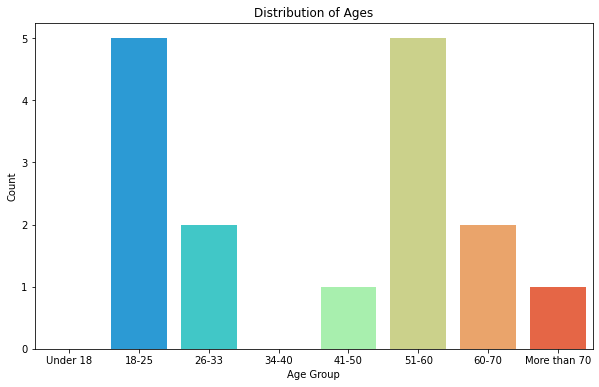

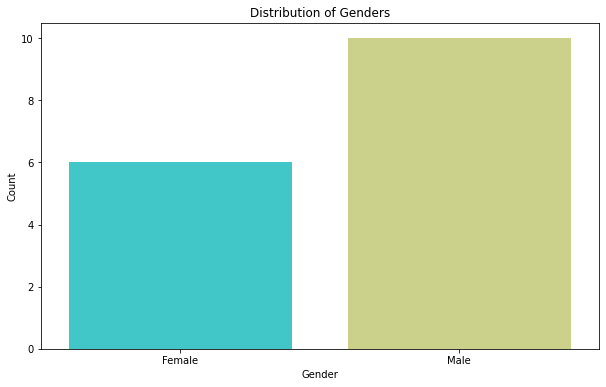

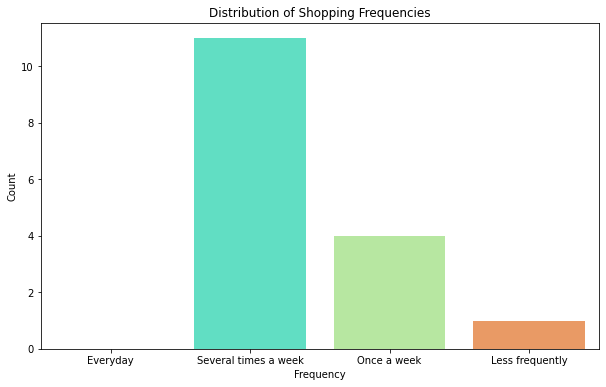

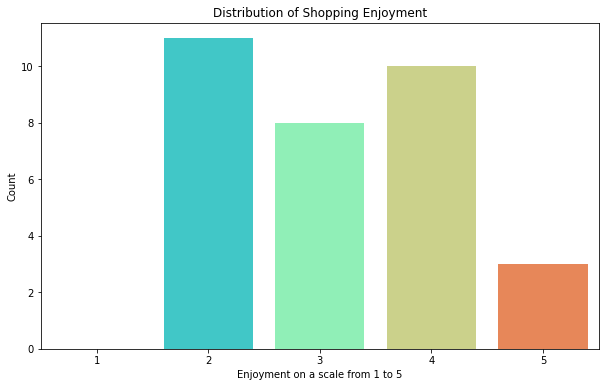

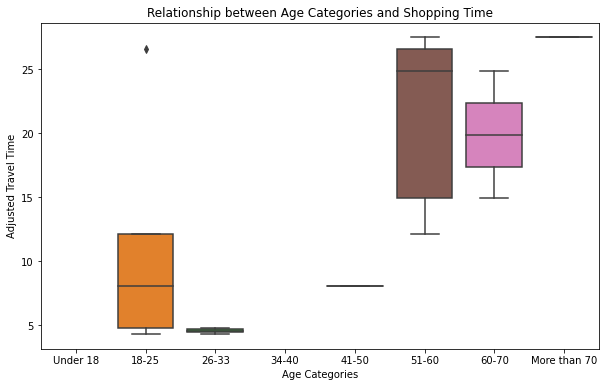

In [42]:
intro_quest = pd.read_csv('Introduction Questionnaire.csv')
intro_quest_cat = pd.read_csv('Introduction Questionnaire Cat.csv') 


image_dir  = "C:/Users/aurel/Downloads/HS23/CIR/Report Images/"

age_mapping = {
    'Menys de 18': 'Under 18',
    'De 18 a 25': '18-25',
    'De 26 a 33': '26-33',
    'De 34 a 40': '34-40',
    'De 41 a 50': '41-50',
    'De 51 a 60': '51-60',
    'De 60 a 70': '60-70',
    'Més de 70': 'More than 70'
}

#AGE 
intro_quest_cat["Edat:"] = intro_quest_cat["Edat:"].replace(age_mapping)
ages = pd.concat([intro_quest_cat['Edat:'], intro_quest['AGE']], axis=0)
category_order = ['Under 18', '18-25', '26-33', '34-40', '41-50', '51-60', '60-70', 'More than 70']
plt.figure(figsize=(10, 6))
sns.countplot(x=ages, data=ages, palette='rainbow', order=category_order)
plt.title('Distribution of Ages')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig(image_dir+'age_distribuition.png') 

intro_quest_cat["Gènere:"] = intro_quest_cat["Gènere:"].replace({'Home':'Male', 'Dona':'Female'})
genders = pd.concat([intro_quest_cat['Gènere:'], intro_quest['GENDER']], axis=0)
plt.figure(figsize=(10, 6))
sns.countplot(x=genders, data=genders, palette='rainbow')
plt.title('Distribution of Genders')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.savefig(image_dir+'gender_distribuition.png') 

frequency_mapping = {
    'Cada dia': 'Everyday',
    'Varies vegades a la setmana': 'Several times a week',
    'Un cop per setmana': 'Once a week',
    'Menys freqüentment': 'Less frequently'
}
intro_quest_cat['En quina freqüència vas a comprar al supermercat?'] = intro_quest_cat['En quina freqüència vas a comprar al supermercat?'].replace(frequency_mapping)
frequencies = pd.concat([intro_quest_cat['En quina freqüència vas a comprar al supermercat?'], intro_quest['How frequently do you visit the supermarket to purchase groceries?']], axis=0)
category_order = ['Everyday', 'Several times a week', 'Once a week', 'Less frequently']
plt.figure(figsize=(10, 6))
sns.countplot(x=frequencies, data=frequencies, palette='rainbow', order=category_order)
plt.title('Distribution of Shopping Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.savefig(image_dir+'shopping_frequency.png') 

enjoyment = pd.concat([intro_quest_cat['En quin grau t\'agrada comprar aliments?'], intro_quest['How much do you enjoy grocery shopping?']], axis=0)
plt.figure(figsize=(10, 6))
sns.countplot(x=enjoyment, data=enjoyment, palette='rainbow', order=list(range(1,6)))
plt.title('Distribution of Shopping Enjoyment')
plt.xlabel('Enjoyment on a scale from 1 to 5')
plt.ylabel('Count')
plt.savefig(image_dir+'enjoyment_frequency.png') 

ages_plot = pd.DataFrame()
ages_plot['age_categories'] = ages 
num_rows = 4 
first_run = pd.concat([first_run.iloc[:-2 * num_rows], first_run.iloc[-num_rows:], first_run.iloc[-2 * num_rows:-num_rows]])
first_run.reset_index(drop=True, inplace=True) 
ages_plot[['user_id', 'adjusted_time_shopping']] = first_run[['user_id', 'adjusted_time_shopping']]
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_categories', y='adjusted_time_shopping', data=ages_plot, order=['Under 18', '18-25', '26-33', '34-40', '41-50', '51-60', '60-70', 'More than 70'])
plt.title('Relationship between Age Categories and Shopping Time')
plt.xlabel('Age Categories')
plt.ylabel('Adjusted Travel Time')
plt.savefig(image_dir+'age_shopping.png') 


total_items = pd.concat([first_run['products_list'],second_run['products_list']], axis=0)
 
# Flatten the lists and count occurrences
all_items = [item for sublist in total_items for item in sublist]
item_counts = Counter(all_items)

# Find the most common items
most_common_items = item_counts.most_common()

# Print or use the most common items and their counts
print(most_common_items)


Elaborate After Questionnaires

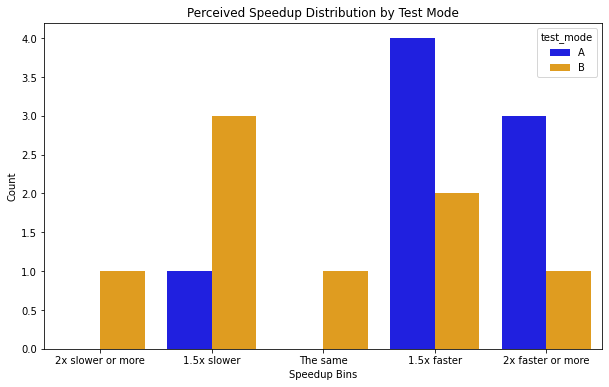

p-value for the perceived speedup: 0.0078125
p-value for the user feedback: 0.036132361111101505


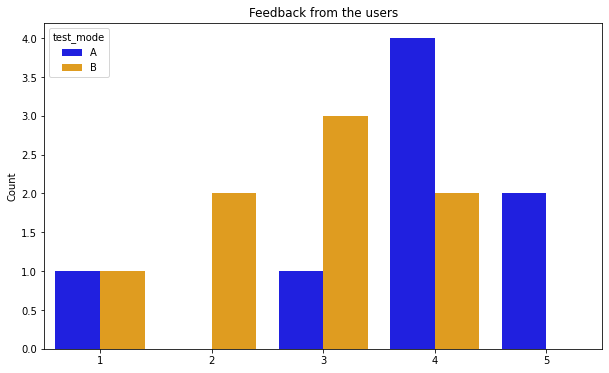

In [29]:
after_quest = pd.read_csv('After Questionnaire.csv')
after_quest_cat = pd.read_csv('After Questionnaire Cat.csv') 

speedup_mapping = {
    '2 vegades més ràpida o més' : '2x faster or more',
    '1.5 vegades més ràpid': '1.5x faster',
    'Igual': 'The same',
    '1.5 vegades més lent' : '1.5x slower',
    '2 vegades més lent o més' : '2x slower or more'
}
perceive_speedups = pd.DataFrame()
after_quest_cat['Quina creus que va ser la diferència de velocitat en la teva experiència de compra utilitzant el robot guía, més ràpida o més lenta?'] = after_quest_cat['Quina creus que va ser la diferència de velocitat en la teva experiència de compra utilitzant el robot guía, més ràpida o més lenta?'].replace(speedup_mapping)
perceive_speedups['speedups'] = pd.concat([after_quest_cat['Quina creus que va ser la diferència de velocitat en la teva experiència de compra utilitzant el robot guía, més ràpida o més lenta?'], after_quest['How much faster/slower do you think your shopping experience was?']], axis = 0, ignore_index=True)
perceive_speedups['test_mode'] = pd.concat([after_quest_cat['(Supervisor) Quin mode has testejat:'], after_quest['(Supervisor) Testing mode:']], axis = 0, ignore_index=True)
perceive_speedups['user_id'] = pd.concat([after_quest_cat['user_id'], after_quest['user_id']], axis = 0, ignore_index=True)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='speedups', hue='test_mode', data=perceive_speedups, palette={'A': 'blue', 'B': 'orange'}, order = ['2x slower or more', '1.5x slower', 'The same', '1.5x faster','2x faster or more'])
plt.title('Perceived Speedup Distribution by Test Mode')
plt.xlabel('Speedup Bins')
plt.ylabel('Count')
plt.savefig(image_dir+'perceived_speedup_distribuition.png')
plt.show()

# Perform Wilcoxon signed-rank test
without_app = [1,1,1,1,1,1,1,1]
with_app = [0.66,1.5,1.5,1.5,1.5,2,2,2]

statistic, p_value = wilcoxon(with_app, without_app, alternative='greater')
print(f'p-value for the perceived speedup: {p_value}')

#Now analyze the data experience
feedback = pd.DataFrame()
feedback['feedback'] = pd.concat([after_quest_cat['Com descriuries la teva experiència global amb l\'aplicació de la llista de la compra i el robot guia?'], after_quest['How would you describe your overall experience with the shopping list application and the guiding robot?']], axis = 0, ignore_index=True)
feedback['test_mode'] = pd.concat([after_quest_cat['(Supervisor) Quin mode has testejat:'], after_quest['(Supervisor) Testing mode:']], axis = 0, ignore_index=True)
feedback['user_id'] = pd.concat([after_quest_cat['user_id'], after_quest['user_id']], axis = 0, ignore_index=True)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='feedback', hue='test_mode', data=feedback, palette={'A': 'blue', 'B': 'orange'})
plt.title('Feedback from the users')
plt.xlabel('')
plt.ylabel('Count')
plt.savefig(image_dir+'user_feedback.png')

feedback_a = feedback.loc[feedback['test_mode'] == 'A']['feedback'].to_list()
feedback_b = feedback.loc[feedback['test_mode'] == 'B']['feedback'].to_list()


statistic, p_value = mannwhitneyu(feedback_b, feedback_a, alternative='less')
print(f'p-value for the user feedback: {p_value}')


Elaborate Log Data

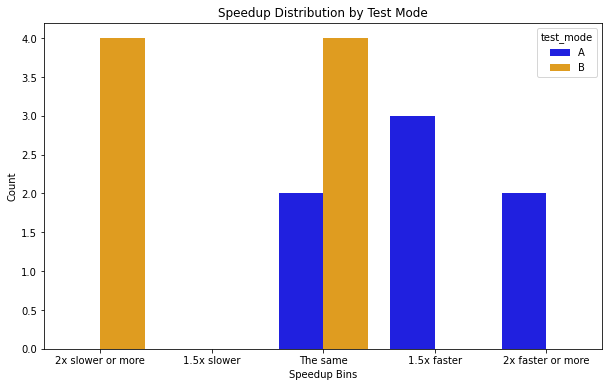

0.008477559775931861


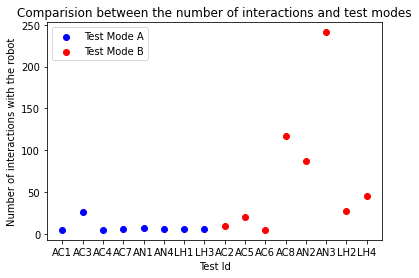

In [23]:
from scipy.stats import wilcoxon,mannwhitneyu

#Observed Speedups in travelling the supermarket
speedups = pd.DataFrame()
speedups['speedups'] = first_run['adjusted_time_shopping']/second_run['adjusted_time_shopping']
speedups[['user_id','test_mode','adjusted_time_shopping','ideal_length']] = first_run[['user_id','test_mode','adjusted_time_shopping','ideal_length']]

# Define bin bounds
bin_bounds = [0,0.5,0.7,1.4,2,5]

# Create a new column for bins
speedups['bin'] = pd.cut(speedups['speedups'], bins=bin_bounds, labels=['2x slower or more', '1.5x slower', 'The same', '1.5x faster','2x faster or more'])

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='bin', hue='test_mode', data=speedups, palette={'A': 'blue', 'B': 'orange'})
plt.title('Speedup Distribution by Test Mode')
plt.xlabel('Speedup Bins')
plt.ylabel('Count')
plt.savefig(image_dir+'speedup_distribuition.png')
plt.show()

#Compare number of interactions between the Test Modes
interactions_a = second_run.loc[second_run['test_mode']=='A']['num_interactions'].to_list()
interactions_b = second_run.loc[second_run['test_mode']=='B']['num_interactions'].to_list()

# Plotting
plt.scatter(second_run.loc[second_run['test_mode']=='A']['user_id'].to_list(), interactions_a, color='blue', label='Test Mode A', marker='o')
plt.scatter(second_run.loc[second_run['test_mode']=='B']['user_id'].to_list(), interactions_b, color='red', label='Test Mode B', marker='o')

# Adding labels and legend
plt.title('Comparision between the number of interactions and test modes')
plt.xlabel('Test Id')
plt.ylabel('Number of interactions with the robot')
plt.legend()
plt.savefig(image_dir+'num_interactions.png')

statistic, p_value = mannwhitneyu(interactions_a, interactions_b, alternative='less')
print(p_value)

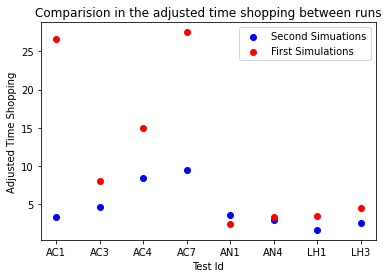

0.01171875


In [19]:
# Sample data (replace this with your actual data)
with_app = second_run.loc[second_run['test_mode']=='A']['adjusted_time_shopping'].to_list()
without_app = first_run.loc[first_run['test_mode']=='A']['adjusted_time_shopping'].to_list()

# Plotting
plt.scatter(second_run.loc[second_run['test_mode']=='A']['user_id'].to_list(), with_app, color='blue', label='Second Simuations', marker='o')
plt.scatter(first_run.loc[second_run['test_mode']=='A']['user_id'].to_list(), without_app, color='red', label='First Simulations', marker='o')

# Adding labels and legend
plt.title('Comparision in the adjusted time shopping between runs')
plt.xlabel('Test Id')
plt.ylabel('Adjusted Time Shopping')
plt.legend()
plt.savefig(image_dir+'speed_comparison.png')
plt.show()

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(with_app, without_app, alternative='less')
print(p_value)
